<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C3/C3.html"><img src="../data/C3_nav.png" width="100"  style="float:right;" alt="C3"></a>
<h1>Feature Normalization</h1> 
</div>

<br/>

<p>
In this notebook, we introduce different strategies for normalizing a feature representation. Parts of the notebook follow Section 3.1.2.1 and Section 2.2.3.3 of <a href="http://www.music-processing.de">[Müller, FMP, Springer 2015]</a>.
</p> 

## Formal Definition of a Norm 

In previous notebooks, we introduced various feature representations including [spectral features](../C2/C2_STFT-Basic.html), [log-frequency spectral features](../C3/C3S1_SpecLogFreq-Chromagram.html), and [chroma features](../C3/C3S1_SpecLogFreq-Chromagram.html). Such features are typically elements of an Euclidean space of some dimension $K\in\mathbb{N}$. In the following, we denote this **feature space** by $\mathcal{F}=\mathbb{R}^K$. Often one needs a measure that assigns to a feature a size or some kind of length, which leads us to the notion of a **norm**. In mathematical terms, given a vector space (e.g., $\mathcal{F}=\mathbb{R}^K$), a norm is a nonnegative function $p:\mathcal{F} \to \mathbb{R}_{\geq 0}$ that satisfies three properties:

* Triangle inequality: $p(x + y) \leq p(x) + p(y)$ for all $x,y\in\mathcal{F}$.

* Positive scalability: $p(\alpha x) = |\alpha| p(x)$ for all $x\in\mathcal{F}$ and $\alpha\in\mathbb{R}$. 

* Positive definiteness: $p(x) = 0$ if an only if $x=0$.

The number $p(x)$ for a vector $x\in\mathcal{F}$ is called the **length** of the vector. Furthermore, a vector with $p(x)=1$ is also called **unit vector**. Note that there is a large number of different norms. In the following, we only consider the vector space $\mathcal{F}=\mathbb{R}^K$ and discuss three specific norms that play a role in the FMP notebooks.

## Euclidean Norm

The most commonly used norm is the **Euclidean norm** (or $\ell^2$-norm). This norm is often denoted by $\|\cdot\|_2$ and defined by

$$
   \|x\|_2 = \sqrt{\langle x\mid x\rangle} = \Big(\sum_{k=1}^K x(k)^2\Big)^{1/2}
$$

for a vector $x=(x(1),x(2),\ldots,x(K))^\top \in\mathbb{R}^K$.  The Euclidean norm $\|x\|_2$  gives the usual distance from the origin $(0,0)$ to the point $x$. The set of unit vectors with regard to the Euclidean norm forms a **unit sphere** denoted as $S^{K-1}\subset\mathbb{R}^K$. In the case of $K=2$, the unit sphere is the unit circle $S^1$ with origin $(0,0)$. 

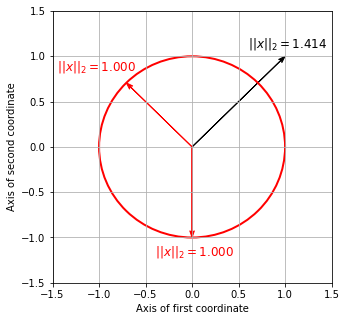

In [1]:
import os, sys
import numpy as np
import scipy
from matplotlib import pyplot as plt
import librosa
import IPython.display as ipd
from numba import jit

sys.path.append('..')
import libfmp.b

%matplotlib inline

def norm_Euclidean(x):
    p = np.sqrt(np.sum(x ** 2))
    return p
    
def plot_vector(x,y, color='k', start=0, linestyle='-'):    
    return plt.arrow(np.real(start), np.imag(start), x, y, 
                     linestyle=linestyle, head_width=0.05, 
                     fc=color, ec=color, overhang=0.3, length_includes_head=True)

fig, ax = plt.subplots(figsize=(5, 5))
plt.grid()  
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.xlabel('Axis of first coordinate')
plt.ylabel('Axis of second coordinate')

circle = plt.Circle((0, 0), 1, color='r', fill=0, linewidth=2)  
ax.add_artist(circle)

x_list = [np.array([[1, 1], [0.6, 1.1]]),
          np.array([[-np.sqrt(2)/2, np.sqrt(2)/2], [-1.45, 0.85]]),
          np.array([[0, -1], [-0.4, -1.2]])]

for y in x_list:
    x = y[0, :]
    p = norm_Euclidean(x)
    color = 'r' if p == 1 else 'k'
    plot_vector(x[0], x[1], color=color)
    plt.text(y[1, 0], y[1, 1], r'$||x||_2=%0.3f$'% p, size='12', color=color) 

## Manhattan Norm

In the **Manhattan norm** (or $\ell^1$-norm), the length of a vector is measured by summing up the absolute values of the vector's Cartesian coordinates. The Manhattan norm, denoted $\|\cdot\|_1$, is defined by 

$$
   \|x\|_1 = \sum_{k=1}^K |x(k)|
$$

for a vector $x=(x(1),x(2),\ldots,x(K))^\top \in\mathbb{R}^K$. The name of the norm comes from the grid-like layout of the streets in Manhattan, which forces a taxi to follow straight lines between the street's intersection points. In the Manhattan norm, the set of unit vectors forms a square with sides oriented at a $45$ degree angle to the coordinate axes. For the case $K=2$, the unit circle of the Manhattan norm is describe by $|x(1)| + |x(2)| = 1$.  

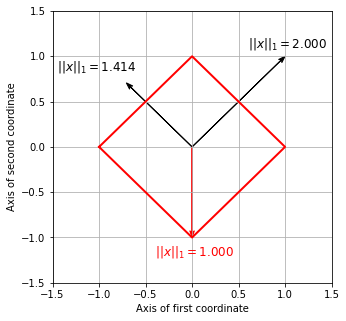

In [2]:
def norm_Manhattan(x):
    p = np.sum(np.abs(x))
    return p
    
fig, ax = plt.subplots(figsize=(5, 5))
plt.grid()  
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.xlabel('Axis of first coordinate')
plt.ylabel('Axis of second coordinate')

plt.plot([-1, 0, 1, 0, -1], [0, 1, 0, -1, 0], color='r', linewidth=2)

for y in x_list:
    x = y[0, :]
    p = norm_Manhattan(x)
    color = 'r' if p == 1 else 'k'
    plot_vector(x[0], x[1], color=color)
    plt.text(y[1, 0], y[1, 1], r'$||x||_1=%0.3f$' % p, size='12', color=color)

## Maximum Norm

In the **maximum norm** (or $\ell^\infty$-norm), the length of a vector is measured by its maximum absolute Cartesian coordinate. The maximum norm, denoted by $\|\cdot\|_\infty$, is defined by 

$$
   \|x\|_\infty = \max\big\{|x(k)| \,\,\mathrm{for}\,\, k\in[1:K] \big\}
$$

for a vector $x=(x(1),x(2),\ldots,x(K))^\top \in\mathbb{R}^K$. The set of unit vectors forms the surface of a hypercube with edge length $2$. 

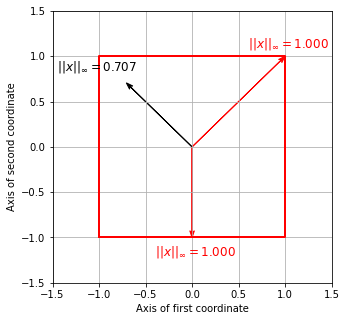

In [3]:
def norm_max(x):
    p = np.max(np.abs(x))
    return p
    
fig, ax = plt.subplots(figsize=(5, 5))
plt.grid()  
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.xlabel('Axis of first coordinate')
plt.ylabel('Axis of second coordinate')

plt.plot([-1, -1, 1, 1, -1], [-1, 1, 1, -1, -1], color='r', linewidth=2)

for y in x_list:
    x = y[0, :]
    p = norm_max(x)
    color = 'r' if p == 1 else 'k'
    plot_vector(x[0], x[1], color=color)
    plt.text(y[1, 0], y[1, 1], r'$||x||_\infty=%0.3f$' % p, size='12', color=color)

## Feature Normalization

In music processing, audio recordings are typically transformed into a feature representation. Often, these representations consists of a sequence $X=(x_1,x_2,\ldots x_N)$ with feature vectors $x_n \in  \mathcal{F}=\mathbb{R}^K$ for $n\in[1:N]$. To better compare feature representations, one often applies **normalization**. One normalization strategy is to choose a suitable norm $p$ and then to replace each feature vector $x_n\in\mathcal{F}$ by $x_n/p(x_n)$. This strategy works as long as $x_n$ is a nonzero vector. Note that the normalized feature vector  $x_n/p(x_n)$ is a unit vector with regard to the norm $p$.

As an example, we consider the case that $X=(x_1,x_2,\ldots x_N)$ is a sequence of [chroma features](../C3/C3S1_SpecLogFreq-Chromagram.html). In this case, the feature space $\mathcal{F}=\mathbb{R}^K$ has the dimension $K=12$. The normalization procedure as described above replaces each chroma vector by its normalized version. As a result, a normalized chroma vector only encodes **relative** rather than **absolute** differences in the sizes of the twelve chroma coefficients. Intuitively speaking, normalization introduces a kind of **invariance** to differences in **dynamics** or **sound intensity**.

The normalization procedure is only possible if $p(x)\not= 0$. Also for very small values $p(x)$, which may occur in passages of silence before the actual start of the recording or during long pauses, normalization would lead to more or less random and therefore meaningless chroma value distributions. Therefore, if $p(x)$ falls below a certain threshold, the vector $x$ may be replaced by some standard vector such as a uniform vector of norm one instead of dividing by $p(x)$.

Mathematically, this normalization procedure can be described as follows. Let $S^{K-1}\subset\mathbb{R}^{K}$ be the unit sphere containing all $K$-dimensional vectors of norm one. Then, for a given threshold $\varepsilon>0$, we define a projection operator $\pi^{\varepsilon}:\mathbb{R}^{K}\to S^{K-1}$ by

\begin{equation}
\pi^{\varepsilon}(x):=
\left\{\begin{array}{cl} x / p(x) & \,\,\,\mbox{if}\,\, p(x) > \varepsilon\\
          u & \,\,\,\mbox{if}\,\, p(x) \leq \varepsilon \end{array}\right.
\end{equation}

where $u=v/p(v)$ is the unit vector of the all-one vector $v=(1,1,\ldots,1)^\top\in\mathbb{R}^K$. Based on this operator, each chroma vector $x$ can be replaced by $\pi^{\varepsilon}(x)$. The threshold $\varepsilon$ is a parameter that needs to be chosen with care. A suitable choice will depend on the requirements of the application in mind. One can think of many variants for this normalization. Obviously, the normalization depends on the chosen norm and on the threshold. Furthermore, instead of taking the equally distributed unit vector $u$, one may take any another vector to represent feature vectors of small size. 

## Example: C-Major Scale

As an example, we consider a piano recording of a C-major scale. As described in the [FMP notebook on logarithmic compression](../C3/C3S1_LogCompression.html), we convert the audio recording into a chroma-based feature sequence. The following figure shows the effect of various normalization procedures. In particular, it shows how the normalization compensates the strong decay in amplitude for each of the notes.

<img src="../data/C3/FMP_C3_F08a.png" width="400px" align="left" alt="C1">

<br clear="all" />

<audio src="../data/C3/FMP_C3_F08_C-major-scale_pause.wav" type="audio/mpeg" controls="controls"></audio>

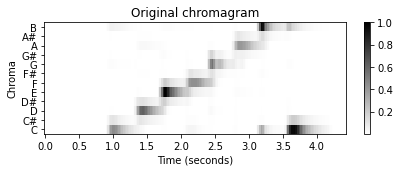

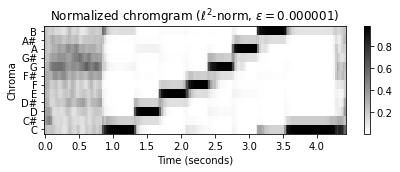

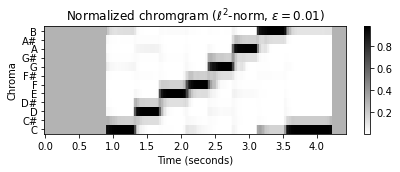

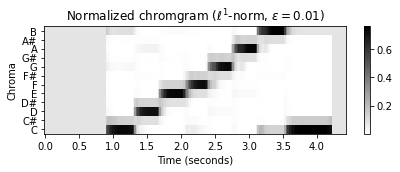

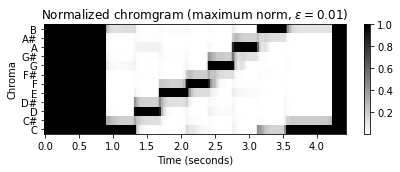

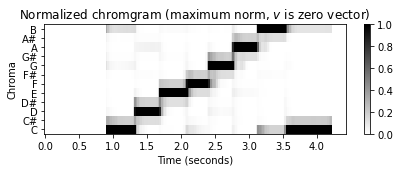

In [4]:
@jit(nopython=True)
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Notebook: C3/C3S1_FeatureNormalization.ipynb

    Args:
        X (np.ndarray): Feature sequence
        norm (str): The norm to be applied. '1', '2', 'max' or 'z' (Default value = '2')
        threshold (float): An threshold below which the vector ``v`` used instead of normalization
            (Default value = 0.0001)
        v (float): Used instead of normalization below ``threshold``. If None, uses unit vector for given norm
            (Default value = None)

    Returns:
        X_norm (np.ndarray): Normalized feature sequence
    """
    assert norm in ['1', '2', 'max', 'z']

    K, N = X.shape
    X_norm = np.zeros((K, N))

    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'max':
        if v is None:
            v = np.ones(K, dtype=np.float64)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'z':
        if v is None:
            v = np.zeros(K, dtype=np.float64)
        for n in range(N):
            mu = np.sum(X[:, n]) / K
            sigma = np.sqrt(np.sum((X[:, n] - mu) ** 2) / (K - 1))
            if sigma > threshold:
                X_norm[:, n] = (X[:, n] - mu) / sigma
            else:
                X_norm[:, n] = v

    return X_norm

fn_wav = os.path.join('..', 'data', 'C3', 'FMP_C3_F08_C-major-scale_pause.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs)

N, H = 4096, 512
C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
C = C / C.max()

figsize=(6, 2.5)
libfmp.b.plot_chromagram(C, Fs=Fs/H, figsize=figsize, title='Original chromagram')

threshold = 0.000001
C_norm = normalize_feature_sequence(C, norm='2', threshold=threshold)
libfmp.b.plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, 
        title = r'Normalized chromgram ($\ell^2$-norm, $\varepsilon=%f$)' % threshold)

threshold = 0.01
C_norm = normalize_feature_sequence(C, norm='2', threshold=threshold)
libfmp.b.plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, 
        title = r'Normalized chromgram ($\ell^2$-norm, $\varepsilon=%0.2f$)' % threshold)

threshold = 0.01
C_norm = normalize_feature_sequence(C, norm='1', threshold=threshold)
libfmp.b.plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, 
        title = r'Normalized chromgram ($\ell^1$-norm, $\varepsilon=%0.2f$)' % threshold)

threshold = 0.01
C_norm = normalize_feature_sequence(C, norm='max', threshold=threshold)
libfmp.b.plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, 
        title = r'Normalized chromgram (maximum norm, $\varepsilon=%0.2f$)' % threshold)

threshold = 0.01
v = np.zeros(C.shape[0])
C_norm = normalize_feature_sequence(C, norm='max', threshold=threshold, v=v)
libfmp.b.plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, 
        title = r'Normalized chromgram (maximum norm, $v$ is zero vector)');

## Normalization by Mean and Variance

Motivated by statistics, one can introduce for a feature $x=(x(1),x(2),\ldots,x(K))^\top \in\mathbb{R}^K$ its **mean** $\mu(x)$ and **variance** $\sigma(x)$, which are defined by

\begin{eqnarray}
\mu(x) &=& \frac{1}{K} \sum_{k=1}^K x_k,\\
\sigma(x) &=& \left(\frac{1}{K-1} \sum_{k=1}^K \big(x_k-\mu(x)\big)^2\right)^{1/2}.
\end{eqnarray}

Based on these statistics, one can normalize a feature vector by considering its **standard score** $z(x)$, which is calculated as 

$$
    z(x) = \frac{x-\mu(x)}{\sigma(x)}.
$$

We demonstrate the effect of this normalization by continuing our example above. Again, we introduce a threshold parameter to avoid division by zero. Note that, even when starting with a features vector with entirely nonnegative coefficients, the standard score may have some negative coefficients. In the following visualization, we use a colormap that highlights positive and negative values.

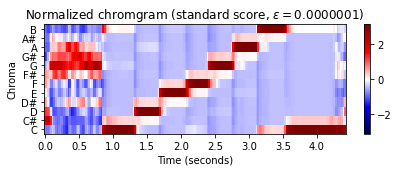

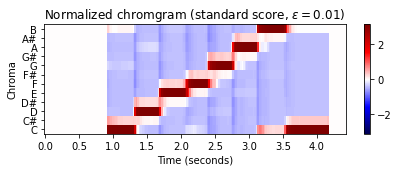

In [5]:
@jit(nopython=True)
def normalize_feature_sequence_z(X, threshold=0.0001, v=None):
    K, N = X.shape
    X_norm = np.zeros((K, N))
    
    if v is None:
        v = np.zeros(K)
        
    for n in range(N):
        mu = np.sum(X[:, n]) / K
        sigma = np.sqrt(np.sum((X[:, n] - mu) ** 2) / (K - 1))
        if sigma > threshold:
            X_norm[:, n] = (X[:, n] - mu) / sigma
        else:
            X_norm[:, n] = v  
            
    return X_norm


threshold = 0.0000001
C_norm = normalize_feature_sequence_z(C, threshold=threshold)
m = np.max(np.abs(C_norm))
libfmp.b.plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, cmap='seismic', clim=[-m, m],
        title = r'Normalized chromgram (standard score, $\varepsilon=%0.7f$)' % threshold)

threshold = 0.01
C_norm = normalize_feature_sequence_z(C, threshold=threshold)
m = np.max(np.abs(C_norm))
libfmp.b.plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, cmap='seismic', clim=[-m, m],
        title = r'Normalized chromgram (standard score, $\varepsilon=%0.2f$)' % threshold);

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>